# Imports

## Library

In [1]:
import torch, os, gc
import numpy as np
from OASIS_2D.oasis import Experiment
from torchvision import models
import matplotlib.pyplot as plt
from OASIS_2D.dataset import OASIS_Dataset

from captum.attr import GuidedGradCam, GradientShap, IntegratedGradients, GuidedBackprop,LayerGradCam, LayerAttribution, Saliency, InputXGradient
# Visualization feature is not working https://github.com/pytorch/captum/issues/1165
from captum.attr import visualization as viz

In [2]:
ViT = False
if ViT:
    result_dir = os.path.join('OASIS_2D', 'results', 'ViT', '1')
else:
    result_dir = os.path.join('OASIS_2D', 'results', 'ResNet', '1')

explainer_map = {
    'gradcam': LayerGradCam,
    'guided_gradcam': GuidedGradCam,
    'integrated_gradients': IntegratedGradients,
    'guided_backprop': GuidedBackprop,
    'gradientshap': GradientShap,
    'saliency': Saliency,
    'input_x_gradient': InputXGradient
}

## Utils

In [3]:
def normalize_scale(
    data: torch.Tensor, dim=1,
    norm_type='standard'
):
    if norm_type == "standard":
        mean = data.mean(dim=dim, keepdim=True)
        std = data.std(dim=dim, keepdim=True)
        return (data - mean) / (std + torch.finfo(torch.float32).eps)

    elif norm_type == "minmax":
        max_val = torch.amax(data, dim=dim, keepdim=True)[0]
        min_val = torch.amin(data, dim=dim, keepdim=True)[0]
        # return (data - min_val) / (max_val - min_val + torch.finfo(torch.float32).eps)
        return (data - min_val) / (max_val - min_val)
        
    elif norm_type == "l1":
        sum_val = data.abs().sum(dim=dim, keepdim=True)
        
        # this converts neg to absolute values
        return data.abs() / (sum_val + torch.finfo(torch.float32).eps)
    else:
        raise (NameError(f'Normalize method "{norm_type}" not implemented'))
    
def visualize(
    attr, x, fig_size=(10, 7), cmap='binary'
):
    # https://captum.ai/api/utilities.html#visualization
    fig, _ = viz.visualize_image_attr_multiple(
        np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
        np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
        methods=["original_image", "heat_map"], # heat_map, blended_heat_map, masked_image, alpha_scaling  
        signs=["all", "absolute_value"], # "all", "positive", "negative", "absolute_value"
        titles=["Original Image", "Heat Map"],
        fig_size=fig_size,
        cmap=cmap,
        show_colorbar=True
    )
    # fig.savefig(os.path.join(result_dir, 'interpretation.jpg'), dpi=200)
    return fig

def visualize_single(
    attr, x, fig_size=(7, 7), 
    method="heat_map",
    cmap='binary', title='Heat Map'
):
    # https://captum.ai/api/utilities.html#visualization
    fig, _ = viz.visualize_image_attr(
        np.transpose(attr.squeeze().cpu().detach().numpy(), (1,2,0)),
        np.transpose(x.squeeze().cpu().detach().numpy(), (1,2,0)),
        method=method, # heat_map, blended_heat_map, masked_image, alpha_scaling  
        sign="absolute_value", # "all", "positive", "negative", "absolute_value"
        title=title,
        fig_size=fig_size,
        cmap=cmap,
        show_colorbar=True
    )
    # fig.savefig(os.path.join(result_dir, 'interpretation.jpg'), dpi=200)
    return fig

# attr_normed = normalize_scale(torch.abs(attr), dim=(-2, -1), norm_type='minmax')
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(x.squeeze()[0].cpu().detach().numpy())
# axes[1].imshow(attr_normed.squeeze()[0].cpu().detach().numpy())
# _ = axes[0].axis('off')
# _ = axes[1].axis('off')

# Device

In [4]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


# Model

In [5]:
if not ViT:
    # https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    model = models.resnet18(weights='DEFAULT')
    num_ftrs = model.fc.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
    model.fc = torch.nn.Linear(num_ftrs, 2)
    last_conv_layer = model.conv1# model.layer4[1].conv2
else:
    model = models.vision_transformer.vit_b_16(weights='DEFAULT')

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model.heads.head.in_features
    # Here the size of each output sample is set to 2.
    # Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
    model.heads.head = torch.nn.Linear(num_ftrs, 2)
    last_conv_layer = model.conv_proj

model = model.to(device)

# Load

In [6]:
from torchvision import transforms

experiment = Experiment(result_dir, device)
model.load_state_dict(torch.load(experiment.best_model_path))

SEED = 2024

if ViT:
    test_dataset = OASIS_Dataset(
        flag='test', seed=SEED, 
        transform=transforms.Compose([
            transforms.ToTensor(), # PIL Image or numpy.ndarray (H x W x C)
            transforms.Resize(224),
            # transforms.CenterCrop(224)
        ]),
        vit=True
    )
else:
    test_dataset = OASIS_Dataset(
        flag='test', seed=SEED
    )

Total 23, disease 13, healthy 10.


In [7]:
N = 3
x = np.array([test_dataset[i][0] for i in range(N)])
y = np.array([test_dataset[i][1] for i in range(N)])

if len(x) == 1:
    x = torch.tensor(np.expand_dims(x, axis=0), device=device)
else:
    x = torch.tensor(x, device=device)
baselines = torch.zeros_like(x) # torch.randn_like(x) 
# for grad methods
x.requires_grad = True

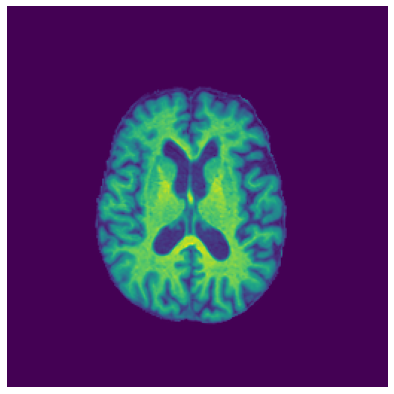

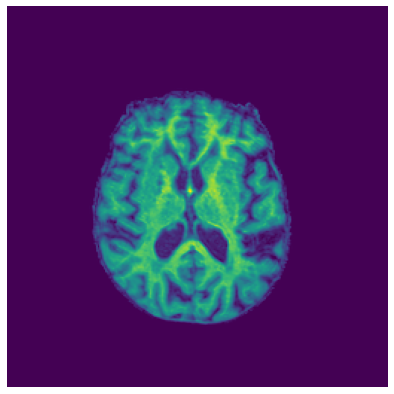

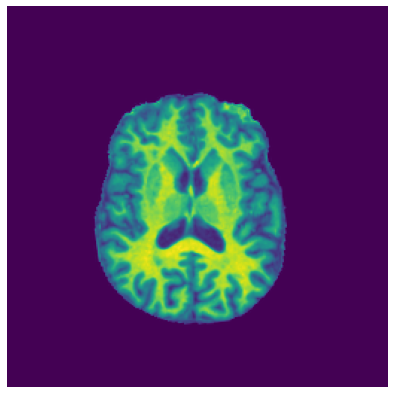

In [8]:
# attr_normed = normalize_scale(torch.abs(attr), dim=(-2, -1), norm_type='minmax')
if len(x) > 1:
    for i in range(len(x)):
        fig, ax = plt.subplots(figsize=(7, 7))
        ax.imshow(x[i].squeeze()[0].cpu().detach().numpy())
        _ = ax.axis('off')
        
        filepath = os.path.join(result_dir, f'sample_{i}.jpg')
        if not os.path.exists(filepath):
            fig.savefig(filepath, dpi=200)
else:
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(x.squeeze()[0].cpu().detach().numpy())
    _ = ax.axis('off')
    
    filepath = os.path.join(result_dir, f'sample.jpg')
    if not os.path.exists(filepath):
        fig.savefig(filepath, dpi=200)

# Interpretation

## Guided GradCam

C:\Users\mi3se\AppData\Roaming\Python\Python310\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:73: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


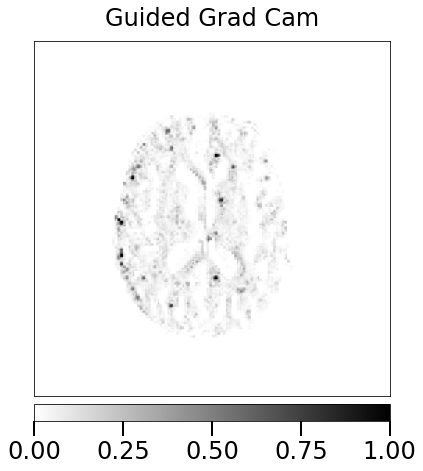

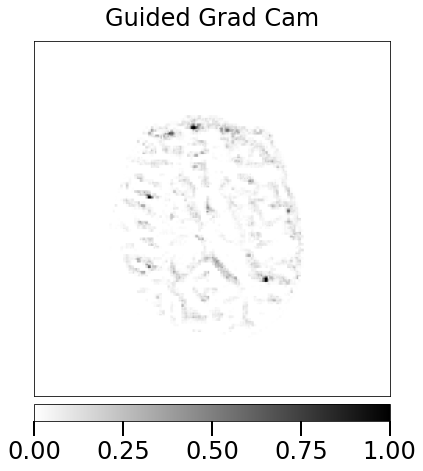

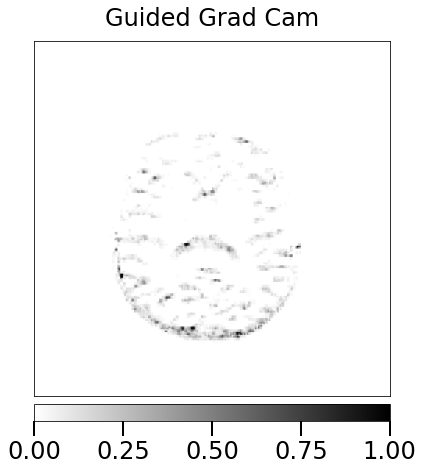

In [9]:
explainer = GuidedGradCam(model, last_conv_layer)
attr = explainer.attribute(x, target=1)
attr_normed = normalize_scale(torch.abs(attr), dim=(-2, -1), norm_type='minmax')

for i in range(len(x)):
    _ = visualize_single(attr_normed[i], x[i], title=explainer.get_name())

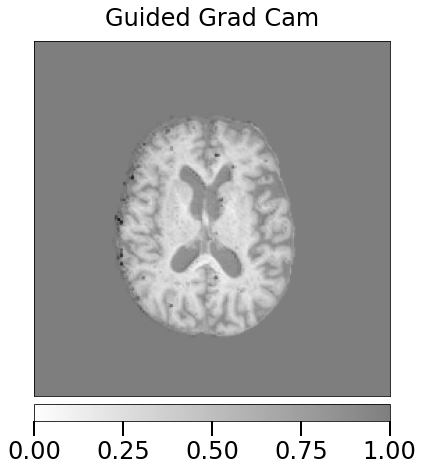

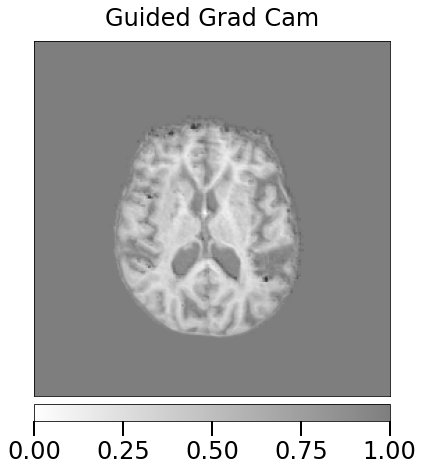

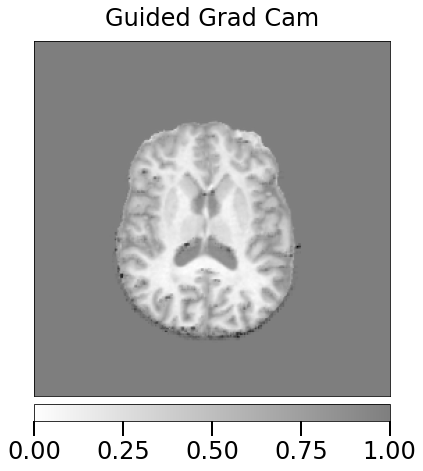

In [10]:
for i in range(len(x)):
    _ = visualize_single(attr_normed[i], x[i], title=explainer.get_name(), method='blended_heat_map')

## GradientShap

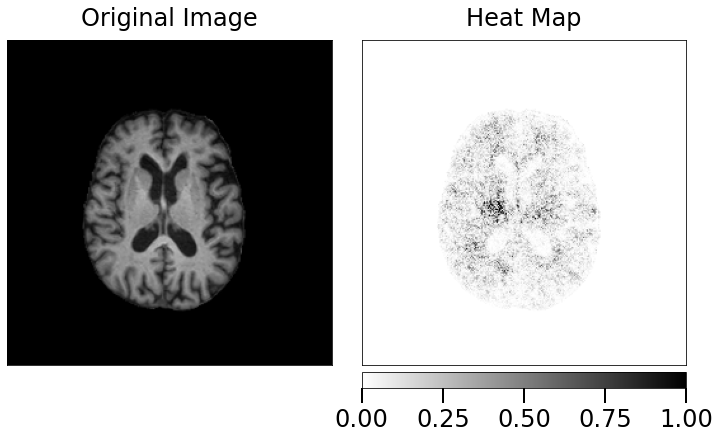

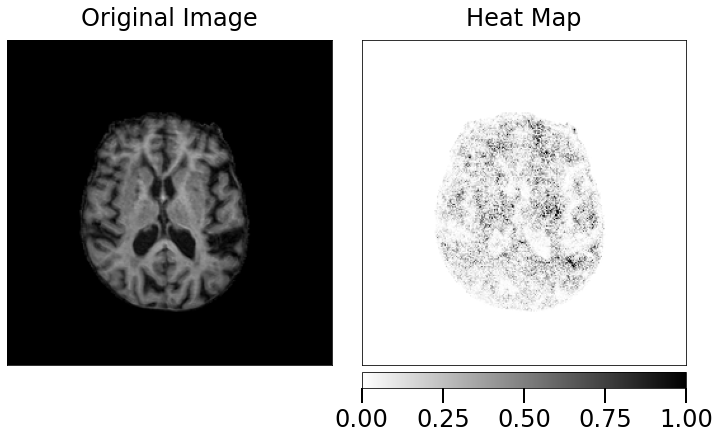

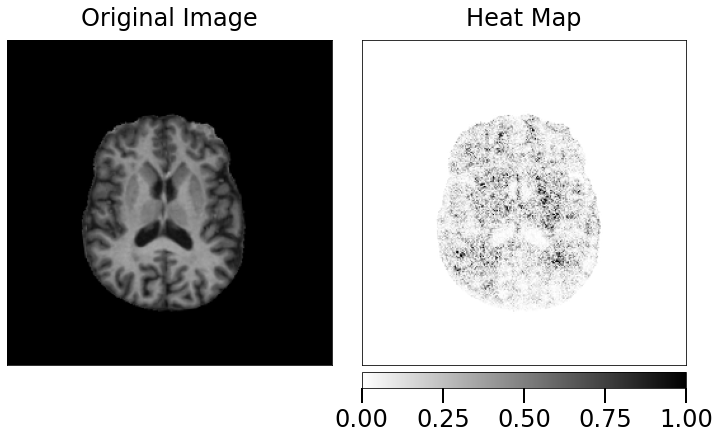

In [11]:
explainer = GradientShap(model)
attr = explainer.attribute(x, target=1, baselines=baselines)

for i in range(len(x)):
    # _ = visualize_single(attr[i], x[i], title=explainer.get_name())
    _ = visualize(attr[i], x[i])

## Integrated Gradients

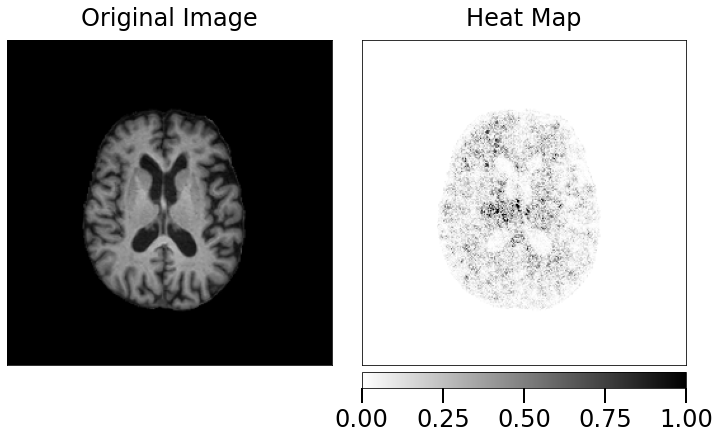

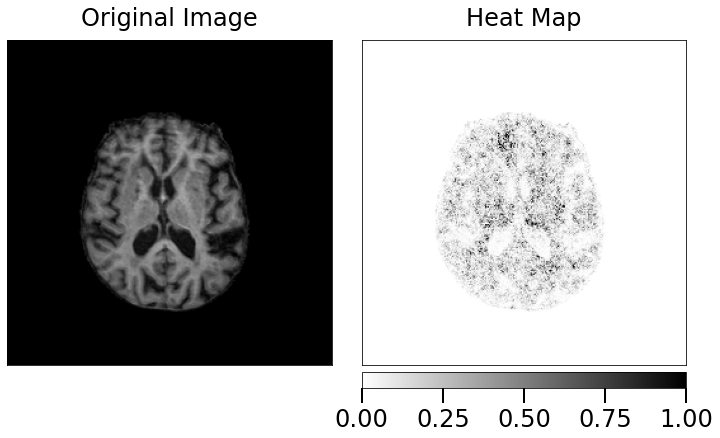

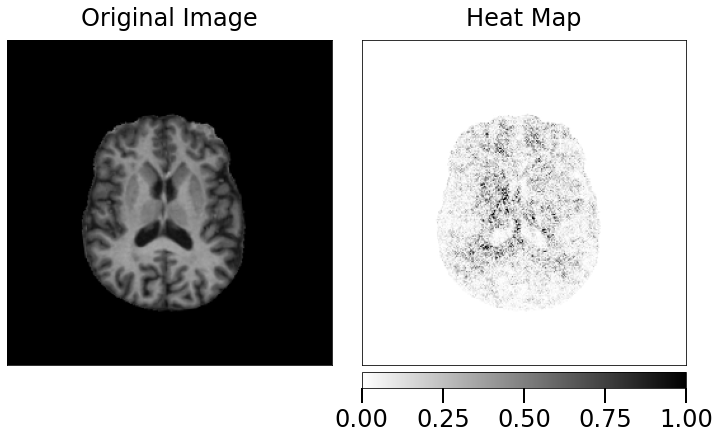

In [12]:
# throws out of memory error for ViT
if not ViT:
    explainer = IntegratedGradients(model)
    attr = explainer.attribute(x, target=1, baselines=baselines)
    # _ = visualize(attr, x)

    for i in range(len(x)):
        # _ = visualize_single(attr[i], x[i], title=explainer.get_name())
        _ = visualize(attr[i], x[i])
        gc.collect()

## Saliency

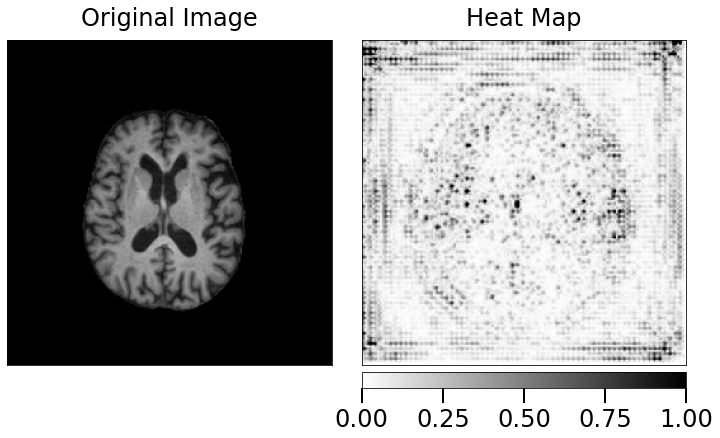

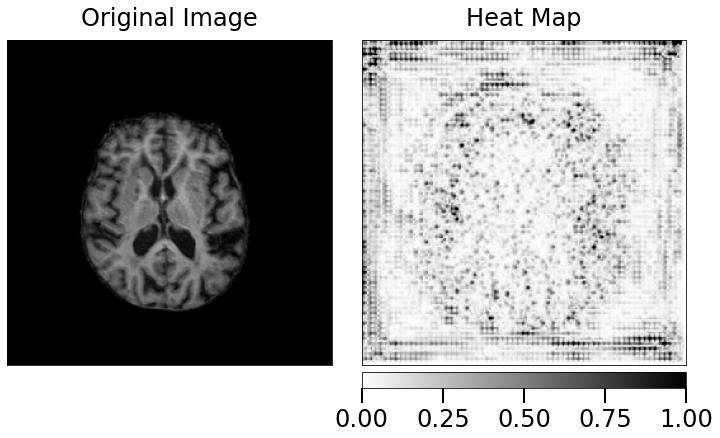

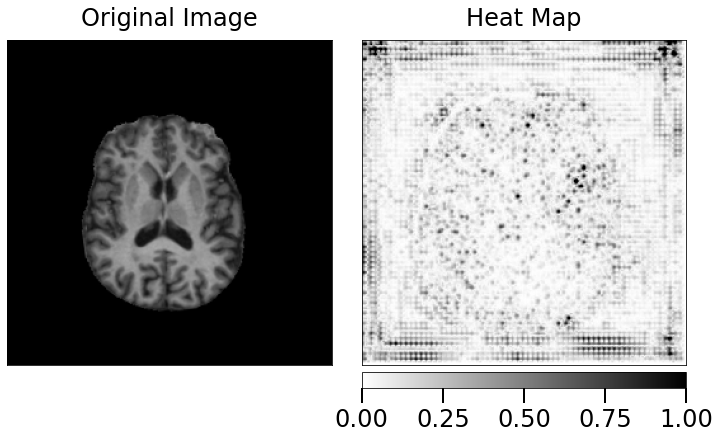

In [13]:
from captum.attr import Saliency, InputXGradient

explainer = Saliency(model)
attr = explainer.attribute(x, target=1)
# _ = visualize(attr, x)

for i in range(len(x)):
    # _ = visualize_single(attr[i], x[i], title=explainer.get_name())
    _ = visualize(attr[i], x[i])
    gc.collect()

## InputXGradient

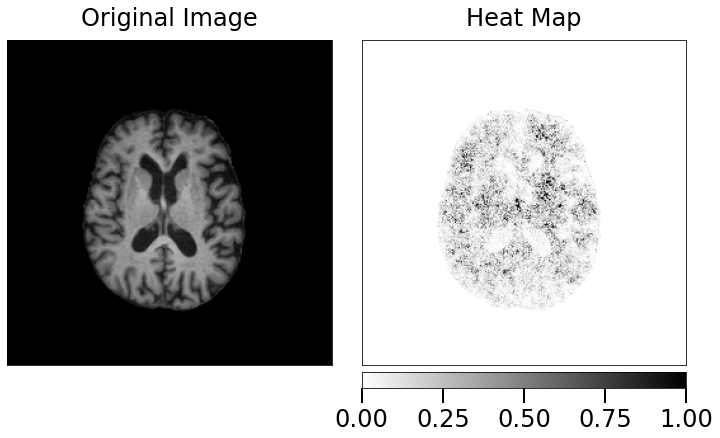

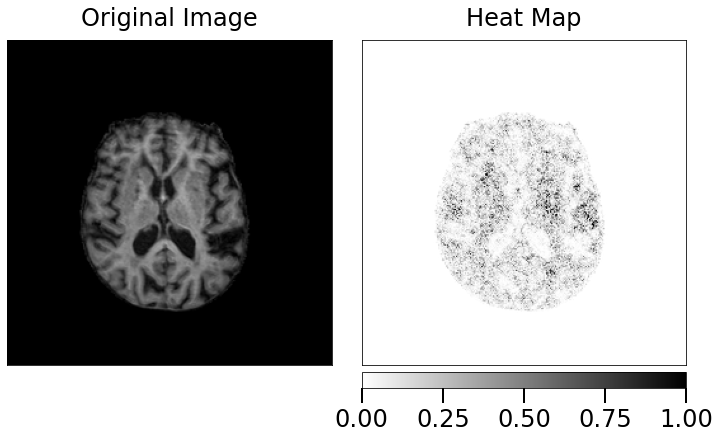

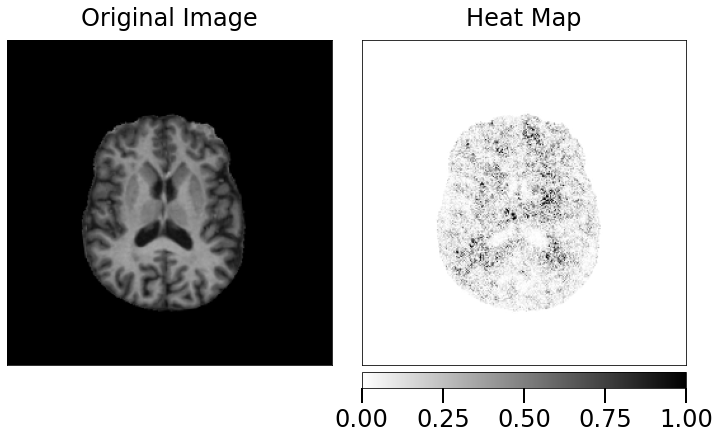

In [14]:
explainer = InputXGradient(model)
attr = explainer.attribute(x, target=1)
# _ = visualize(attr, x)

for i in range(len(x)):
    # _ = visualize_single(attr[i], x[i], title=explainer.get_name())
    _ = visualize(attr[i], x[i])
    gc.collect()

## Guided Backprop

C:\Users\mi3se\AppData\Roaming\Python\Python310\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:73: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


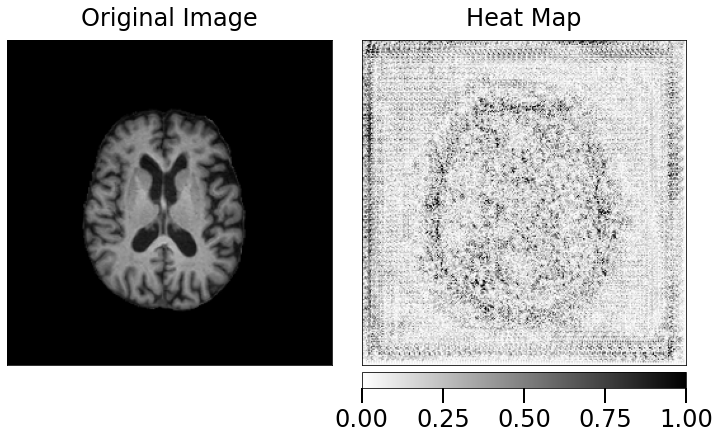

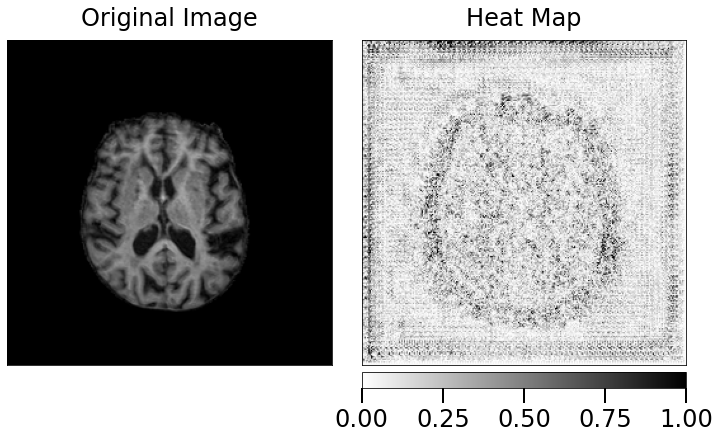

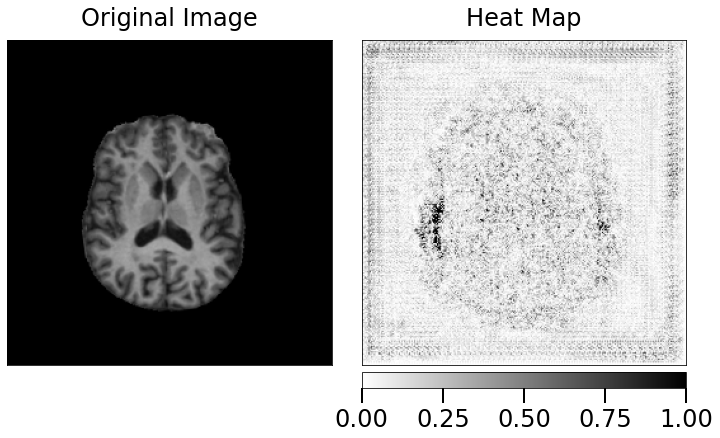

In [15]:
explainer = GuidedBackprop(model)
attr = explainer.attribute(x, target=1)

for i in range(len(x)):
    # _ = visualize_single(attr[i], x[i], title=explainer.get_name())
    _ = visualize(attr[i], x[i])

## GradCam

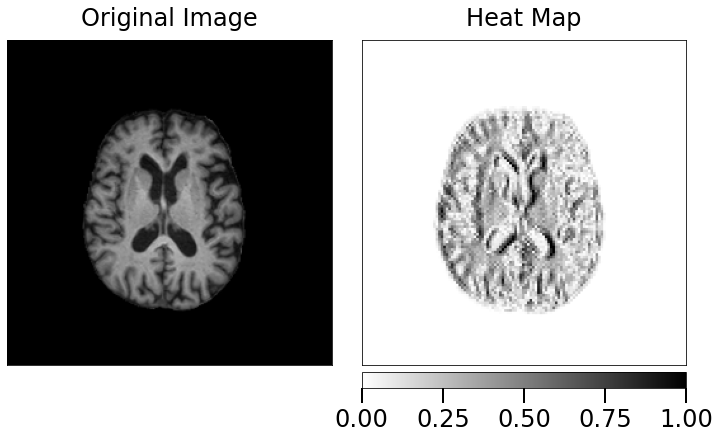

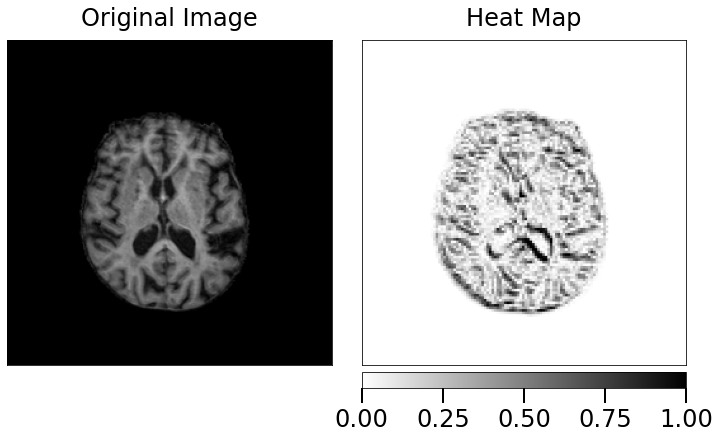

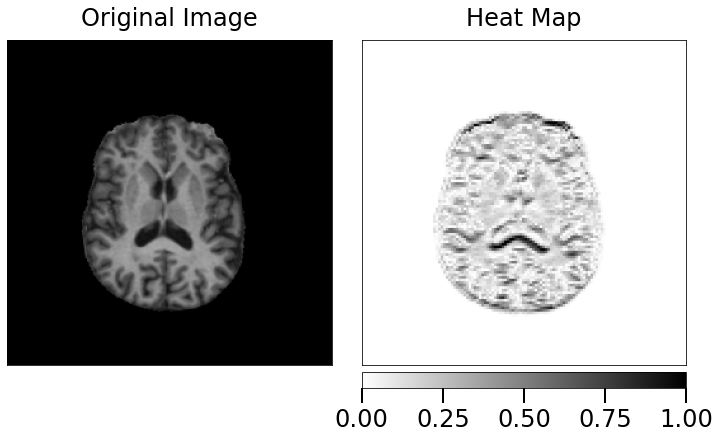

In [16]:
# https://captum.ai/api/layer.html#gradcam
explainer = LayerGradCam(model, last_conv_layer)
attr = explainer.attribute(x, target=1)
# _ = visualize(attr, x)

upsampled_attr = LayerAttribution.interpolate(attr, x.shape[-2:]).repeat((1, 3, 1, 1))

for i in range(len(x)):
    # _ = visualize_single(upsampled_attr[i], x[i], title=explainer.get_name())
    _ = visualize(upsampled_attr[i], x[i])

# Dump

In [17]:
def initialize_explainer(name, model):
    if name in ['gradcam', 'guided_gradcam']:
        return explainer_map[name](model, last_conv_layer)
    else:
        return explainer_map[name](model)
    
def dump(explainer, fig, sample_no=None, method=None):
    interpretation_dir = os.path.join(result_dir, 'interpretation')
    if not os.path.exists(interpretation_dir):
        os.makedirs(interpretation_dir, exist_ok=True)
    
    name = None
    for key in explainer_map:
        if isinstance(explainer, explainer_map[key]):
            name = key
            break
    if name is None:
        raise NotImplementedError
    
    filename = name
    if method is not None:
        filename += f'_{method}'
    if sample_no is not None:
        filename += f'_{sample_no}'
    
    filepath = os.path.join(interpretation_dir, f'{filename}.jpg')
    
    if not os.path.exists(filepath):
        fig.savefig(filepath, dpi=200)

    # plt.close(fig)

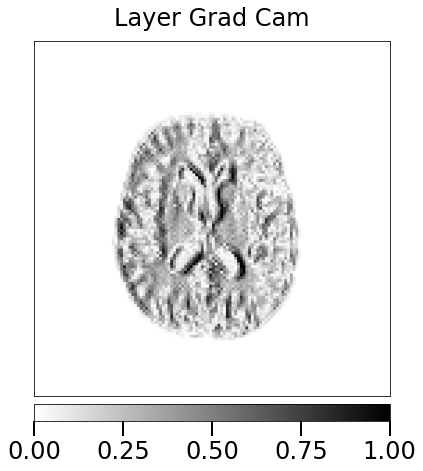

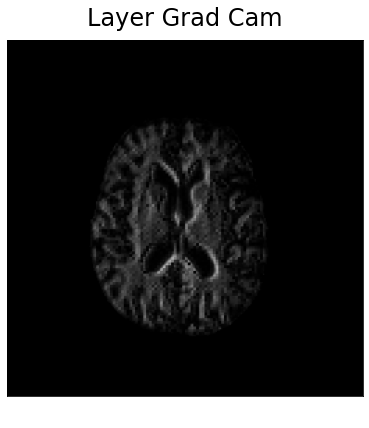

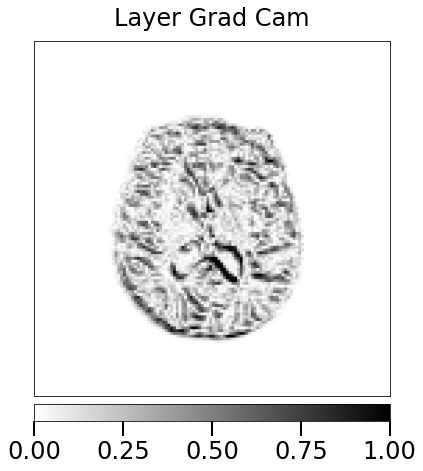

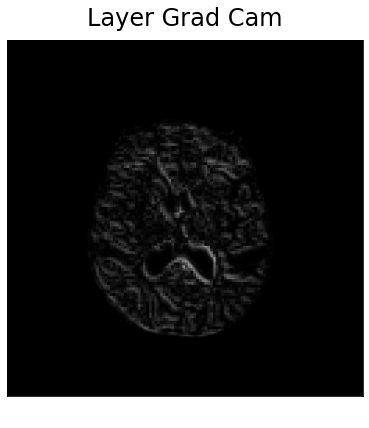

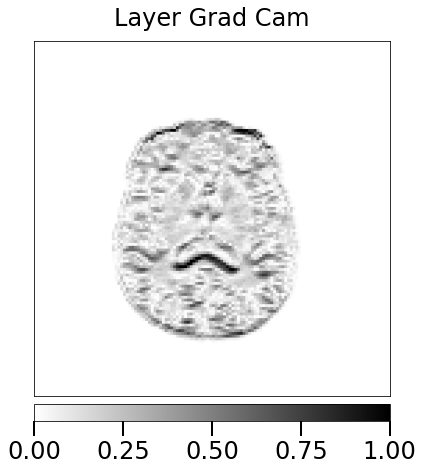

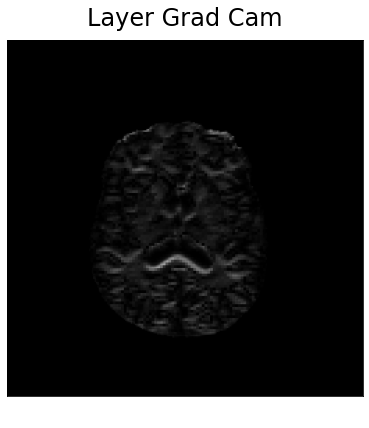

C:\Users\mi3se\AppData\Roaming\Python\Python310\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:73: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


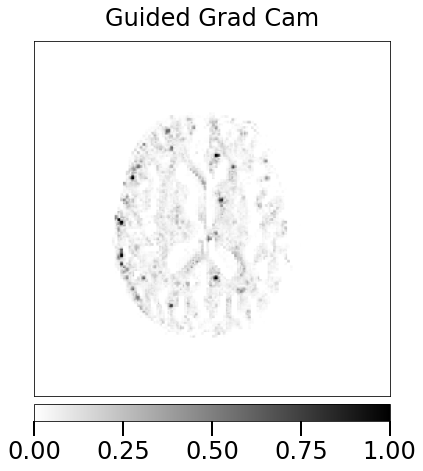

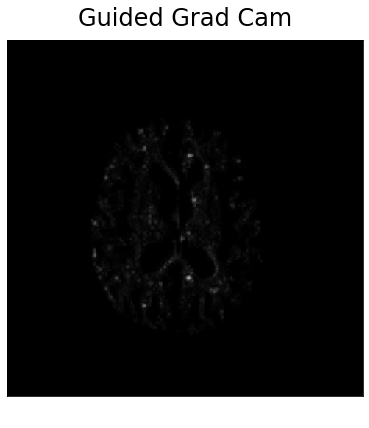

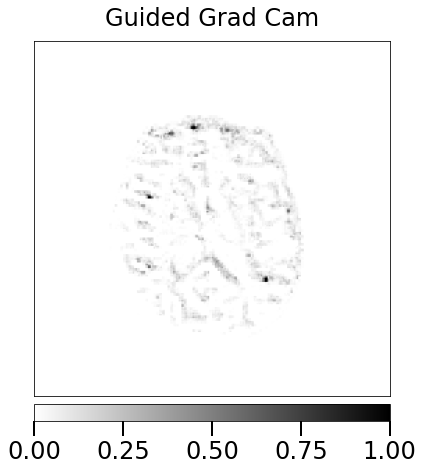

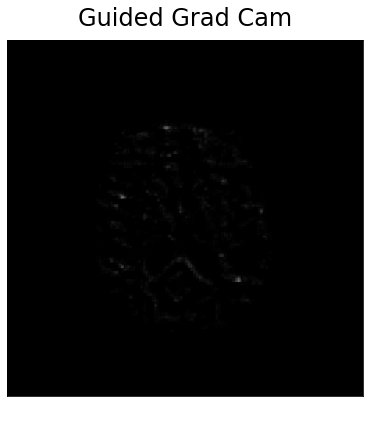

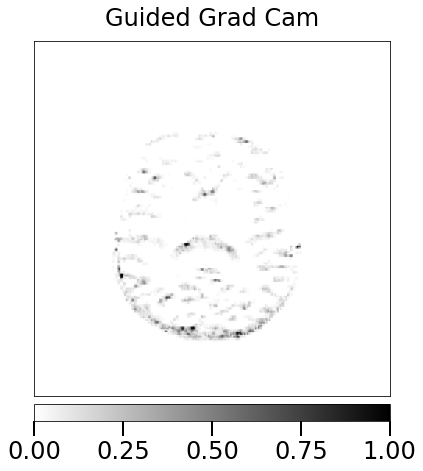

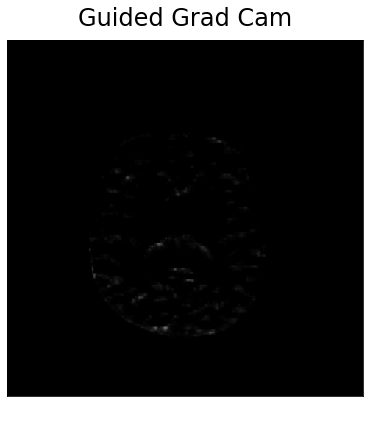

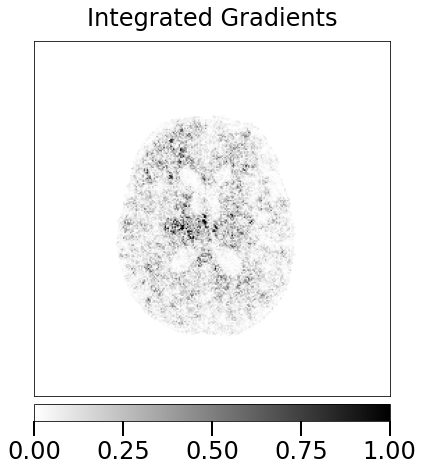

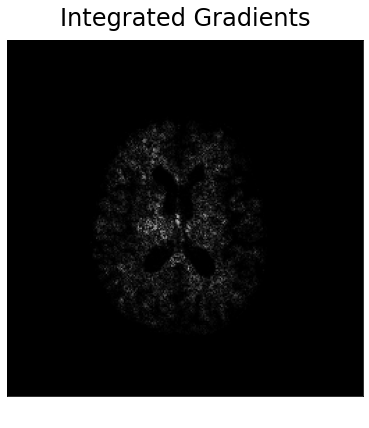

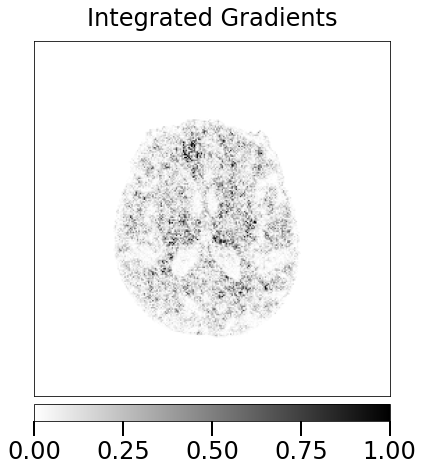

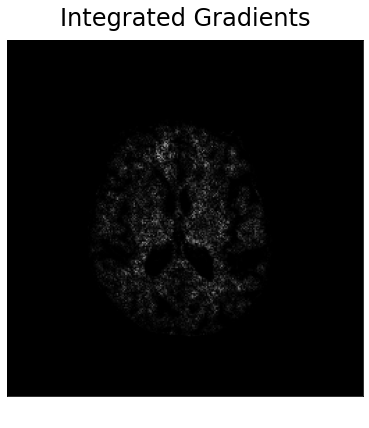

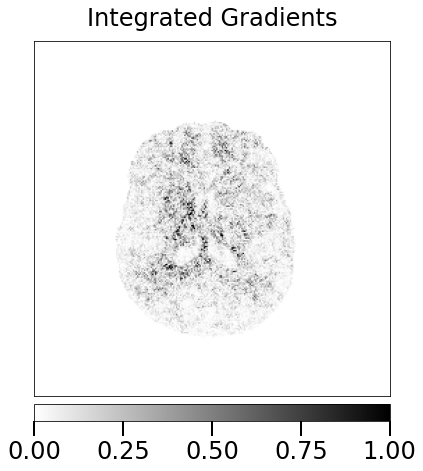

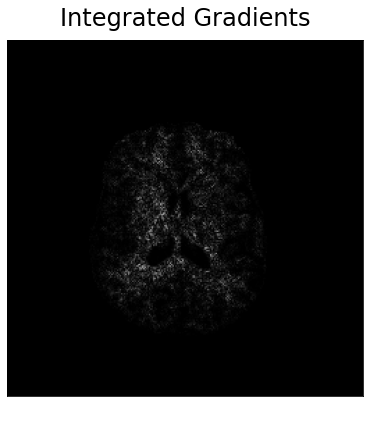

C:\Users\mi3se\AppData\Roaming\Python\Python310\site-packages\captum\attr\_core\guided_backprop_deconvnet.py:73: UserWarning: Setting backward hooks on ReLU activations.The hooks will be removed after the attribution is finished
  warnings.warn(


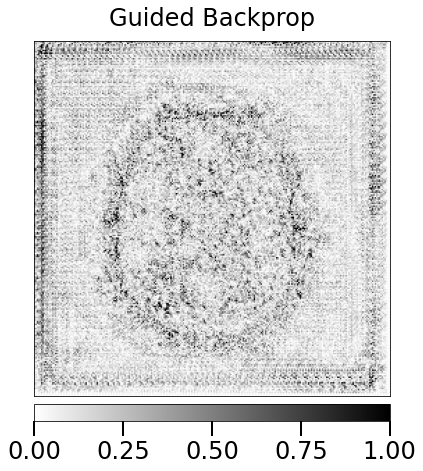

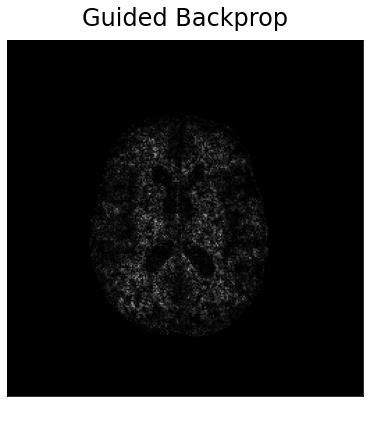

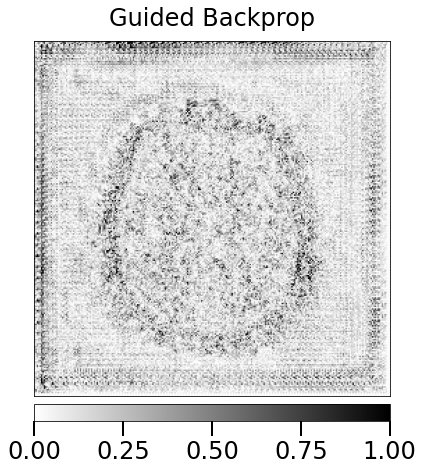

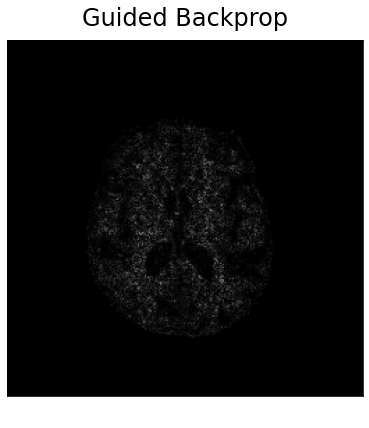

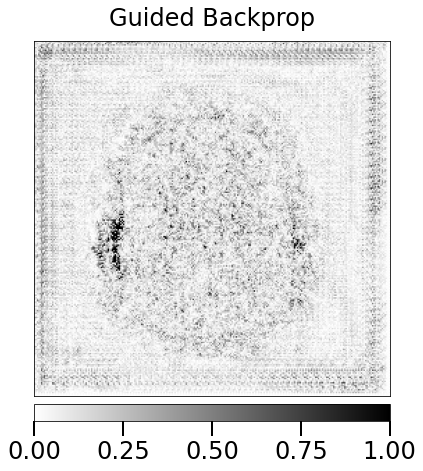

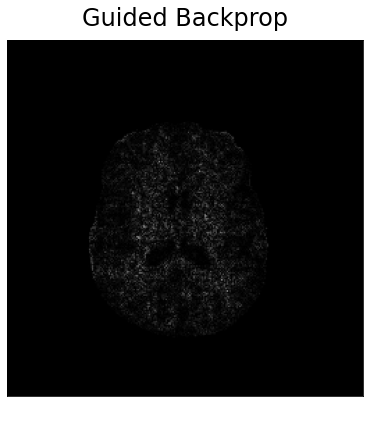

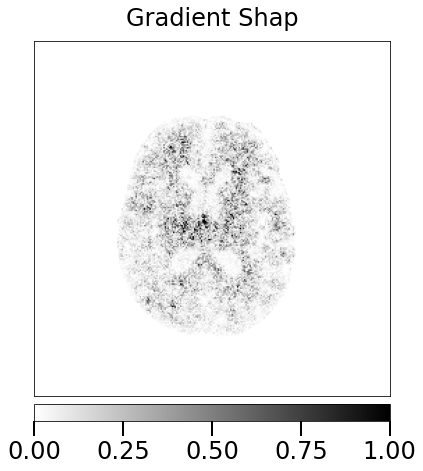

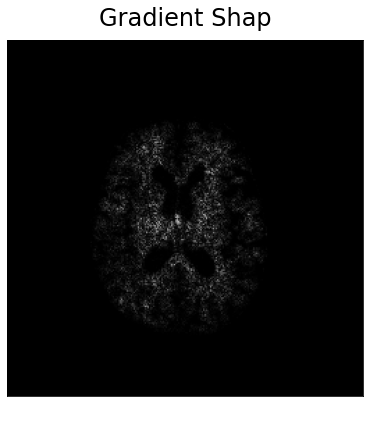

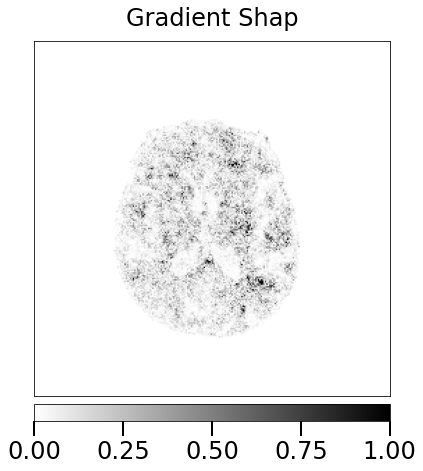

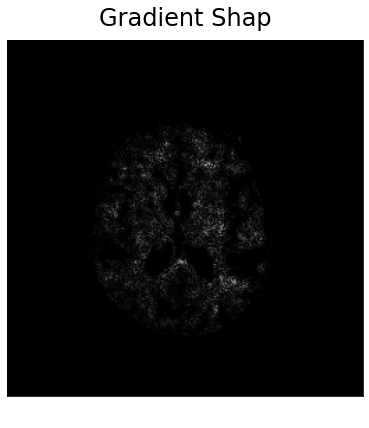

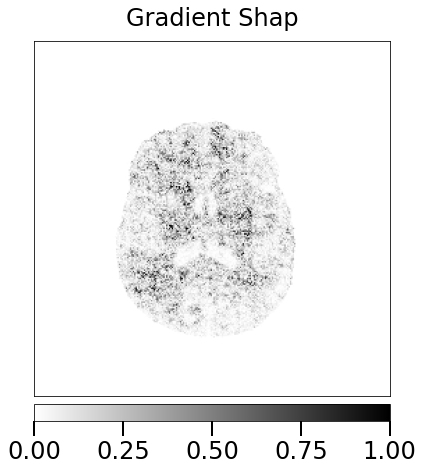

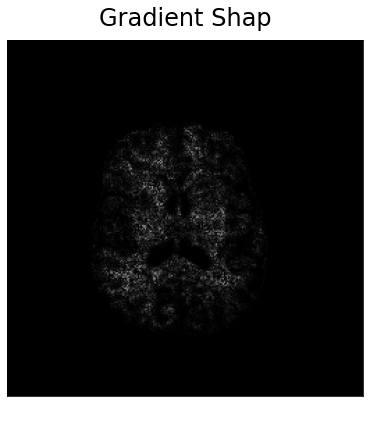

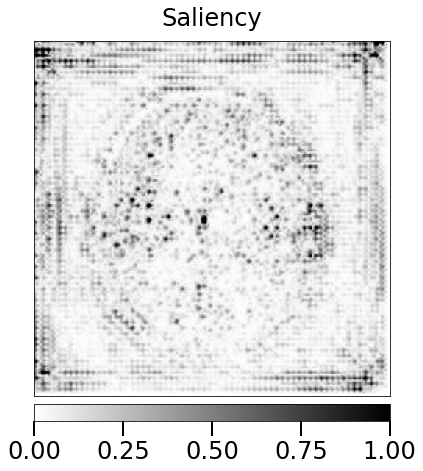

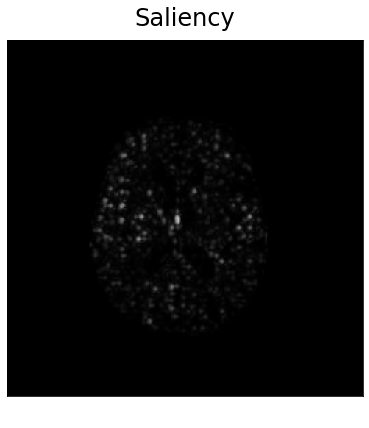

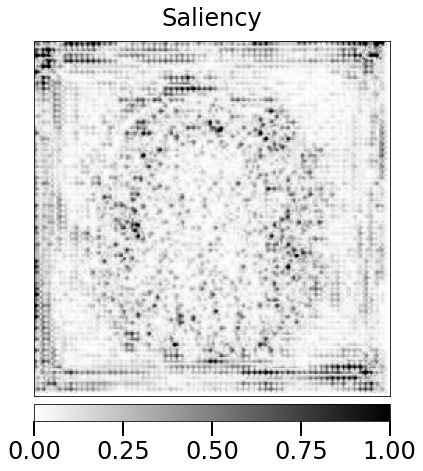

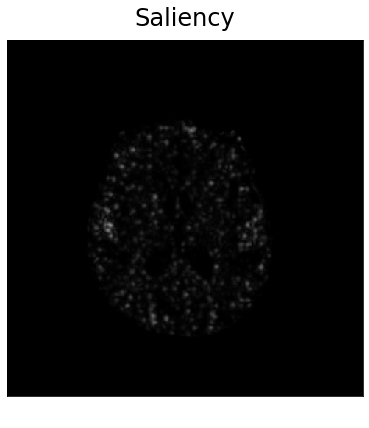

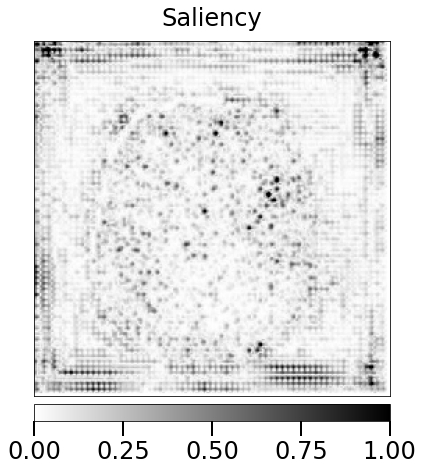

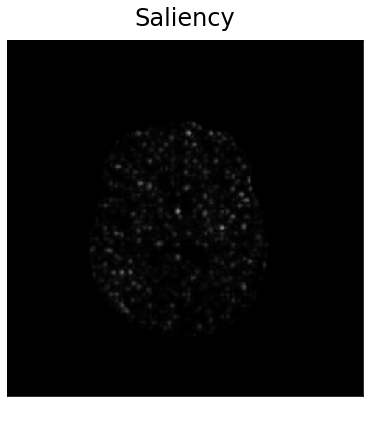

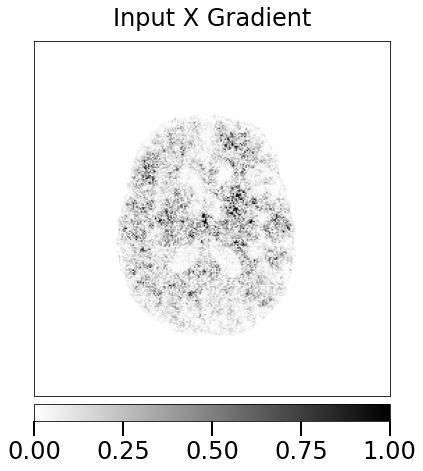

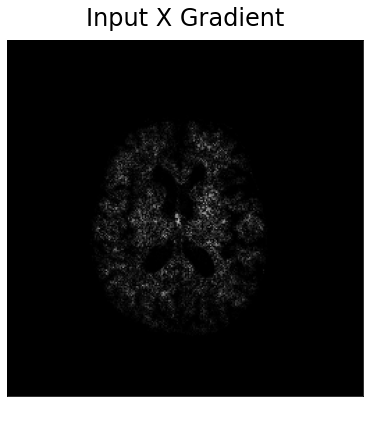

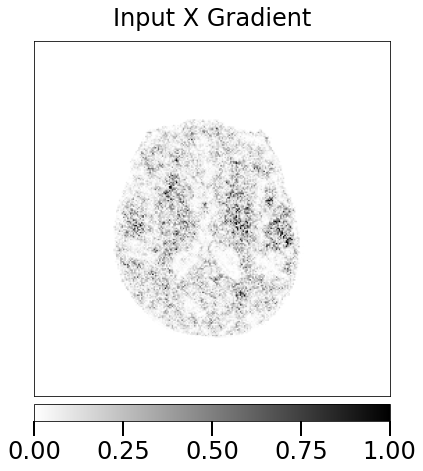

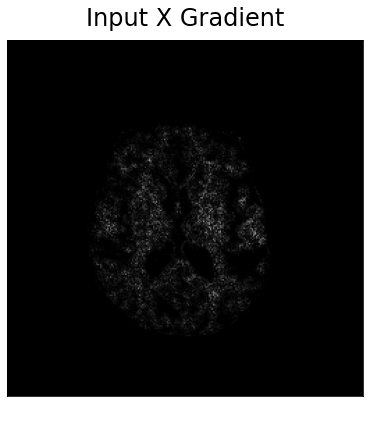

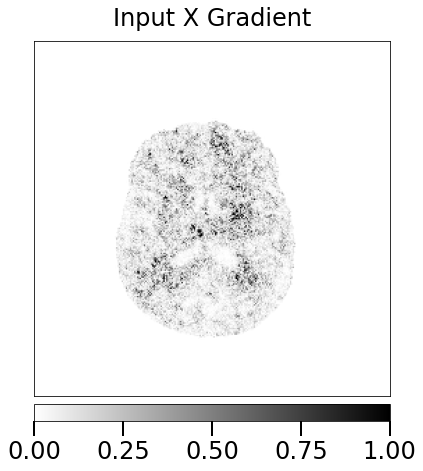

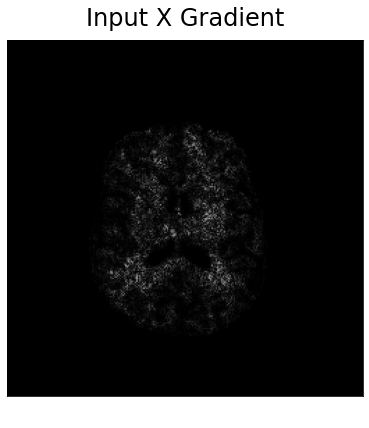

In [18]:
target = 1
for name in explainer_map:
    explainer = initialize_explainer(name, model)
    if name == 'integrated_gradients' and ViT: continue
    
    if name in ['gradcam', 'guided_gradcam']:
        attr = explainer.attribute(x, target=target)
        # _ = visualize(attr, x)

        # the values are very small
        attr_normed = normalize_scale(torch.abs(attr), dim=(-2, -1), norm_type='minmax')
        attr = LayerAttribution.interpolate(attr_normed, x.shape[-2:]).repeat((1, 3, 1, 1))
    elif name in ['integrated_gradients', 'gradientshap']: 
        attr = explainer.attribute(x, target=target, baselines=baselines)
    else: 
        attr = explainer.attribute(x, target=target)

    for i in range(len(x)):
        for method in ['heat_map', 'masked_image']:
            fig = visualize_single(
                attr[i], x[i], title=explainer.get_name(), method=method
            )
            dump(explainer, fig, i, method=method)
        
    gc.collect()